# Калибровка

In [1]:
import adi
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.fft as fft
import scipy.signal as signal
from pandas import read_csv, DataFrame
import matplotlib as mpl
import functools
from timeit import default_timer as timer
%matplotlib inline

In [2]:
sdr = adi.ad9361('ip:172.16.1.246')

In [3]:
sdr.tx_destroy_buffer()
sdr.rx_lo = int(100e6)
sdr.tx_lo = int(100e6)
sdr.sample_rate = int(61.44e6)
sdr.rx_rf_bandwidth = int(1.6 * sdr.sample_rate / 2)
sdr.tx_rf_bandwidth = int(1.6 * sdr.sample_rate / 2)
sdr.gain_control_mode = "slow_attack"
sdr.tx_enabled_channels = [0,1]
sdr.rx_enabled_channels = [0]
sdr.tx_buffer_size = 8192
sdr.rx_buffer_size = 8192
# Подключение: TX2 - RX1
# sdr.tx_destroy_buffer()
sdr.tx_cyclic_buffer = True
sdr.loopback = 0

In [4]:
# Конструктор для сигнала, состоящего из косинусов
def cosines(amplitudes, frequencies):
    return lambda t:  functools.reduce(lambda acc, harmonic: acc + harmonic[0]*np.cos(2 * np.pi * harmonic[1] * t), zip(amplitudes, frequencies), 0)

# Конструктор для сигнала, состоящего из синусов
def sines(amplitudes, frequencies):
    return lambda t:  functools.reduce(lambda acc, harmonic: acc + harmonic[0]*np.sin(2 * np.pi * harmonic[1] * t), zip(amplitudes, frequencies), 0)

def get_averaged_spectrum(sdr, average=10):
    signal = sdr.rx()
    spectrum = fft.fftshift(fft.fft(signal))
    for i in range(average-1):
        signal = sdr.rx()
        spectrum = spectrum + fft.fftshift(fft.fft(signal))
    spectrum = spectrum / average
    frequencies = fft.fftshift(fft.fftfreq(signal.shape[0], 1 / sdr.sample_rate) + sdr.rx_lo) / 1e6
    return DataFrame(data = spectrum.imag**2 + spectrum.real**2, index = frequencies)

def dbg(x):
    print(x)
    return x

In [8]:
sdr.rx_lo=int(100e6)
sdr.tx_lo=int(95e6)
freqs = [5e6]
ts = 1 / float(sdr.sample_rate)
N = sdr.tx_buffer_size
gains = [2**15]
t = np.arange(0, N * ts, ts)
i = cosines(gains, freqs)(t)
q = sines(gains, freqs)(t)
iq = i + 1j * q
# part = int(N/8)
# plt.plot(t[:part], i[:part], '.')
# plt.plot(t[:part], q[:part], '.')
# plt.show()

sdr.tx_destroy_buffer()
sdr.tx_destroy_buffer()
# Send data cyclically
sdr.tx([iq,iq])

In [9]:
spectrum = get_averaged_spectrum(sdr, 100)

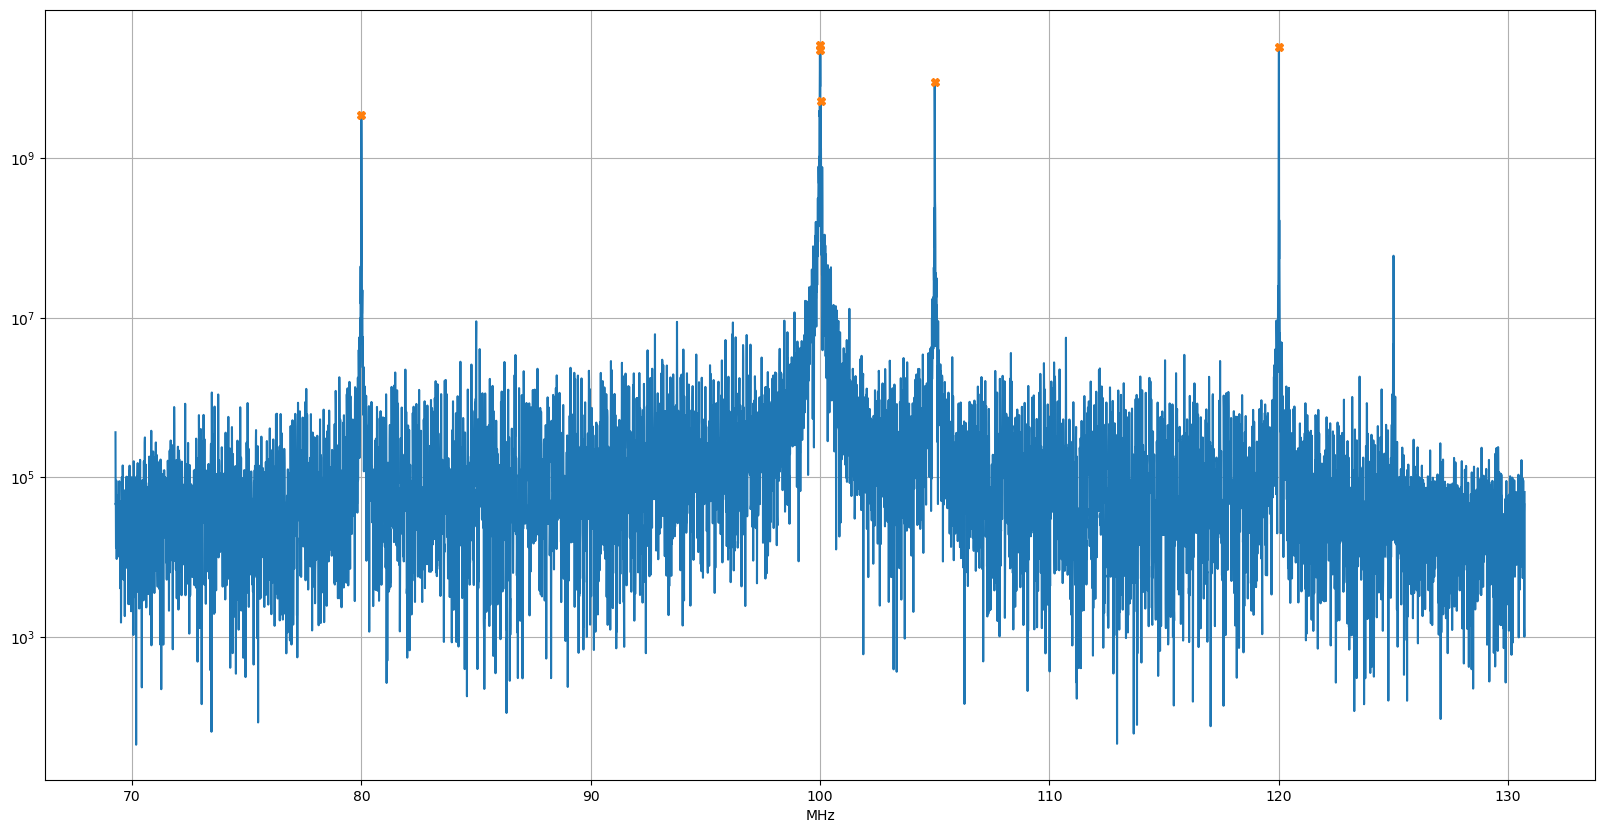

Peak frequencies:
Float64Index([79.9975, 99.9925, 100.0075, 100.0225, 104.995, 120.0025], dtype='float64')


In [10]:
peaks = signal.find_peaks(spectrum[0], prominence = 1e9)[0]
plt.figure(figsize=[20,10])
plt.plot(spectrum)
plt.plot(spectrum.iloc[peaks], "X")
plt.yscale('log')
plt.grid()
plt.xlabel("MHz")
# plt.ylabel("dB")
plt.show()

print("Peak frequencies:")
print(spectrum.iloc[peaks].index)